In [ ]:
%matplotlib inline

In [ ]:
!pip install isoweek

import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
from isoweek import Week

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Colab Notebooks/kaggle-rossmann/dataset/rossmann/'
%cd '/content/drive/MyDrive/Colab Notebooks/kaggle-rossmann'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/kaggle-rossmann


In [ ]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary

# Competencia de Kaggle

[ir a Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)

[3er puesto](https://github.com/entron/entity-embedding-rossmann)

# Métrica de la competencia

$$
\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

donde:

- $y_i$ las ventas de un día particular de un store
- $\hat{y}_i$ ventas estimadas por el modelo
- $n$ es el número de predicciones realizadas

# Importamos dataset

La competencia permitía agregar datos externos para realizar la predicción

The following tables are available in the datasets:

| Archivo      | Descripción| Origen de Datos|
|--------------|--------------------------------------------------------------------|--|
| train.csv        | training set: información del store día a día, ventas, clientes, si es feriado, etc | Kaggle |
| store.csv       | Información general del store, por ejemplo datos del competidor | Kaggle |
| store_states.csv | Mapea de store a estado - Dato externo| Externos |
| state_names.csv  | Mapea estados a acronimo de estado | Externos |
| googletrend.csv  | Tendencias por semana - Dato externo| Externos|
| weather.csv      | Condiciones meteorológicas por día | Externos|

In [ ]:
table_names = ['train', 'test', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, test, store, store_states, state_names, googletrend, weather = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]

# Data visualization

In [ ]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


In [ ]:
display(test.head())
display(DataFrameSummary(test).summary())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


- Mirar counts que todos tienen la misma cantidad
- Ninguno tiene missing
- Los tipos tambien es interesante observar

In [ ]:
train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
display(store.head())
display(DataFrameSummary(store).summary())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


Descripción de algunas columnas que quizas no sean tan claras:

- `Customers`: La cantidad de clientes por día
- `Open`: Indicador si el store estaba abierto o cerrado: 0 = closed, 1 = open
- `StateHoliday`: Indica feriado en ese estado. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- `SchoolHoliday`: Inidica si el store fue afectado por el feriado escolar
- `StoreType`: Tipos de store: a, b, c, d
- `Assortment`: Describe el nivel de surtido de la tienda: a = basic, b = extra, c = extended
- `CompetitionDistance`: Distancia en metros al competidor
- `CompetitionOpenSince[Month/Year]`: Fecha en que abrío la competencia
- `Promo`: Si el store esta corriendo una promoción ese día
- `Promo2`: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- `Promo2Since[Year/Week]`: describes the year and calendar week when the store started participating in Promo2
- `PromoInterval`: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [ ]:
store['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [ ]:
store['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [ ]:
display(store_states.head(20))
display(DataFrameSummary(store_states).summary())

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN
5,6,SN
6,7,SH
7,8,SH
8,9,NW
9,10,"HB,NI"


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


In [ ]:
display(state_names.head(20))
display(DataFrameSummary(state_names).summary())

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB
5,Hamburg,HH
6,Hessen,HE
7,MecklenburgVorpommern,MV
8,Niedersachsen,"HB,NI"
9,NordrheinWestfalen,NW


,StateName,State
count,16,16
unique,16,16
top,Niedersachsen,MV
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


In [ ]:
display(googletrend)
display(DataFrameSummary(googletrend).summary())

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67
...,...,...,...
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


In [ ]:
display(weather)
display(DataFrameSummary(weather[['Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'Precipitationmm']]).summary())

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,Saarland,2015-09-13,21,17,12,16,14,12,100,88,68,1015,1010,1005,31.0,15.0,10.0,27,10,50.0,1.02,7.0,Rain,113
15836,Saarland,2015-09-14,18,14,11,15,12,7,99,85,61,1009,1005,1004,31.0,13.0,4.0,32,16,53.0,9.91,5.0,Rain-Thunderstorm,213
15837,Saarland,2015-09-15,16,12,9,11,8,7,93,77,62,1010,1008,1004,31.0,12.0,10.0,34,14,NaN,0.00,5.0,Rain,193
15838,Saarland,2015-09-16,19,15,11,16,13,10,97,90,75,1004,999,995,31.0,10.0,4.0,32,14,45.0,20.07,7.0,Rain-Thunderstorm,147


,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,Precipitationmm
count,15840,15840,15840,15840,15840,15840,15840,15840,14667,15840
mean,14.6441,10.389,6.19899,93.6596,74.2829,50.1586,22.7666,11.9722,5.55131,0.831718
std,8.64601,7.37926,6.52639,7.67853,13.4866,19.9602,8.98862,5.87284,1.68771,2.51351
min,-11,-13,-15,44,30,4,3,2,0,0
25%,8,4,1,90.75,65,34,16,8,5,0
50%,15,11,7,94,76,49,21,11,6,0
75%,21,16,11,100,85,66,27,14,7,0.25
max,39,31,24,100,100,100,101,53,8,58.93
counts,15840,15840,15840,15840,15840,15840,15840,15840,14667,15840
uniques,51,45,40,53,71,93,44,29,9,41


In [ ]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')

# Data Pre-processing

In [ ]:
train.StateHoliday = train.StateHoliday != '0' # para convertir a booleana

In [ ]:
test.StateHoliday = test.StateHoliday != '0' # para convertir a booleana

In [ ]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

In [ ]:
weather = join_df(weather, state_names, "file", "StateName") # le pego a weather el codigo de los estados

In [ ]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State == 'NI', "State"] = 'HB,NI'

In [ ]:
def add_datepart(df):
  df.Date = pd.to_datetime(df.Date)
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Week'] = df.Date.dt.isocalendar().week
  df['Day'] = df.Date.dt.day

In [ ]:
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

In [ ]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [ ]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [ ]:
joined = join_df(train, store, "Store")
len(joined[joined.StoreType.isnull()])

0

In [ ]:
joined = join_df(joined, googletrend, ["State", "Year", "Week"])
len(joined[joined.trend.isnull()])

0

In [ ]:
joined = joined.merge(trend_de, 'left', ['Year', 'Week'], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()])

0

In [ ]:
joined = join_df(joined, weather, ['State', 'Date'])
len(joined[joined.Mean_TemperatureC.isnull()])

0

In [ ]:
joined_test = join_df(test, store, "Store")
len(joined_test[joined_test.StoreType.isnull()])

0

In [ ]:
joined_test = join_df(joined_test, googletrend, ["State", "Year", "Week"])
len(joined_test[joined_test.trend.isnull()])

0

In [ ]:
joined_test = joined_test.merge(trend_de, 'left', ['Year', 'Week'], suffixes=('', '_DE'))
len(joined_test[joined_test.trend_DE.isnull()])

0

In [ ]:
joined_test = join_df(joined_test, weather, ['State', 'Date'])
len(joined_test[joined_test.Mean_TemperatureC.isnull()])

0

In [ ]:
joined_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       'StateName', 'Ye

In [ ]:
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

In [ ]:
joined_test.CompetitionOpenSinceYear = joined_test.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined_test.CompetitionOpenSinceMonth = joined_test.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined_test.Promo2SinceYear = joined_test.Promo2SinceYear.fillna(1900).astype(np.int32)
joined_test.Promo2SinceWeek = joined_test.Promo2SinceWeek.fillna(1).astype(np.int32)

In [ ]:
joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(x.CompetitionOpenSinceYear, 
          x.CompetitionOpenSinceMonth, 15), axis=1))
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

In [ ]:
joined_test["CompetitionOpenSince"] = pd.to_datetime(joined_test.apply(lambda x: datetime.datetime(x.CompetitionOpenSinceYear, 
          x.CompetitionOpenSinceMonth, 15), axis=1))
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days

In [ ]:
joined.loc[joined.CompetitionDaysOpen < 0, 'CompetitionDaysOpen'] = 0
joined.loc[joined.CompetitionOpenSinceYear < 1990, 'CompetitionDaysOpen'] = 0

In [ ]:
joined_test.loc[joined_test.CompetitionDaysOpen < 0, 'CompetitionDaysOpen'] = 0
joined_test.loc[joined_test.CompetitionOpenSinceYear < 1990, 'CompetitionDaysOpen'] = 0

In [ ]:
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"] // 30
joined.loc[joined.CompetitionMonthsOpen > 24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5])

In [ ]:
joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"] // 30
joined_test.loc[joined_test.CompetitionMonthsOpen > 24, "CompetitionMonthsOpen"] = 24
joined_test.CompetitionMonthsOpen.unique()

array([24, 11,  0, 18, 19, 17, 21, 13,  9,  2, 14,  4,  6, 12,  3, 16, 10,
       15, 20, 22,  5, 23,  7,  1,  8])

In [ ]:
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

In [ ]:
joined_test["Promo2Since"] = pd.to_datetime(joined_test.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days

In [ ]:
joined.loc[joined.Promo2Days <0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear < 1990, "Promo2Days"] = 0

In [ ]:
joined_test.loc[joined_test.Promo2Days <0, "Promo2Days"] = 0
joined_test.loc[joined_test.Promo2SinceYear < 1990, "Promo2Days"] = 0

In [ ]:
joined["Promo2Weeks"] = joined["Promo2Days"] // 7
joined.loc[joined.Promo2Weeks < 0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks > 25, "Promo2Weeks"] = 25
joined["Promo2Weeks"].unique()

array([ 0, 25, 17,  8, 13, 24, 16,  7, 12, 23, 15,  6, 11, 22, 14,  5, 10,
       21,  4,  9, 20,  3, 19,  2, 18,  1])

In [ ]:
joined_test["Promo2Weeks"] = joined_test["Promo2Days"] // 7
joined_test.loc[joined_test.Promo2Weeks < 0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks > 25, "Promo2Weeks"] = 25
joined_test["Promo2Weeks"].unique()

array([ 0, 25, 24, 15, 20, 23, 14, 19, 22, 13, 18, 21, 12, 17, 11, 16, 10,
        9,  8])

In [ ]:
def get_missing_columns(df):
    return list(df.columns[df.describe(include = 'all').loc['count']<len(df)])

In [ ]:
# Si no es dia 7 esta abierto - Verificado que el store 622 esta usualmente cerrado el día 7
joined_test.loc[test['Open'].isna(), 'Open'] = joined_test[joined_test['Open'].isna()]['DayOfWeek'] != 7*1.0

In [ ]:
# Si no tengo la distancia, supongo que no hay (Como si estuviera lejos)
joined_test.loc[joined_test['CompetitionDistance'].isna(), 'CompetitionDistance'] = joined_test['CompetitionDistance'].max()

In [ ]:
joined_test.loc[joined_test['PromoInterval'] == ' ', 'PromoInterval'] = joined['PromoInterval'].unique()[0]
joined_test.loc[joined_test['PromoInterval'].isna() & (joined_test['Promo2'] == 0), 'PromoInterval'] = joined['PromoInterval'].unique()[0]

In [ ]:
joined['PromoInterval'].unique()

array(['', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
joined_test['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
joined_test.loc[joined_test['Events'] == 'Sunny', 'Events'] = 'Rain'

In [ ]:
print(get_missing_columns(joined_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


['State_DE', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Gust_SpeedKm_h', 'CloudCover']


# Durations

In [ ]:
columns = ['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday']

In [ ]:
class elapsed(object):
  def __init__(self, fld):
    self.fld = fld
    self.last = pd.to_datetime(np.nan)
    self.last_store = 0

  def get(self, row):
    if row.Store != self.last_store:
      self.last = pd.to_datetime(np.nan)
      self.last_store = row.Store
    if(row[self.fld]): self.last = row.Date
    return row.Date - self.last

In [ ]:
df = train[columns]

In [ ]:
df_test = test[columns]

In [ ]:
def add_elapsed(fld, prefix):
  sh_el = elapsed(fld)
  df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [ ]:
def add_elapsed_test(fld, prefix):
  sh_el_test = elapsed(fld)
  df_test[prefix+fld] = df_test.apply(sh_el_test.get, axis=1)

In [ ]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [ ]:
fld = 'SchoolHoliday'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed_test(fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed_test(fld, 'Before')

In [ ]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [ ]:
fld = 'StateHoliday'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed_test(fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed_test(fld, 'Before')

In [ ]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [ ]:
fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed_test(fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed_test(fld, 'Before')

In [ ]:
df = df.set_index('Date')

In [ ]:
df_test = df_test.set_index('Date')

In [ ]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [ ]:
for o in ['Before', 'After']:
  for p in columns:
    a = o + p
    df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

In [ ]:
for o in ['Before', 'After']:
  for p in columns:
    a = o + p
    df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

In [ ]:
bwd = df[['Store']+columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()

In [ ]:
bwd_test = df_test[['Store']+columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()

In [ ]:
fwd = df[['Store']+columns].sort_index(ascending=False).groupby('Store').rolling(7, min_periods=1).sum()

In [ ]:
fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby('Store').rolling(7, min_periods=1).sum()

In [ ]:
bwd.drop('Store', 1, inplace=True)
bwd.reset_index(inplace=True)

In [ ]:
bwd_test.drop('Store', 1, inplace=True)
bwd_test.reset_index(inplace=True)

In [ ]:
fwd.drop('Store', 1, inplace=True)
fwd.reset_index(inplace=True)

In [ ]:
fwd_test.drop('Store', 1, inplace=True)
fwd_test.reset_index(inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df_test.reset_index(inplace=True)

In [ ]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [ ]:
df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [ ]:
df.drop(columns, 1, inplace=True)

In [ ]:
df_test.drop(columns, 1, inplace=True)

In [ ]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [ ]:
df_test.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,0,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,0,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,0,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,0,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
df.to_csv('df-GE.csv')

In [ ]:
df_test.to_csv('df_test-GE.csv')

In [ ]:
df = pd.read_csv('df-GE.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df_test = pd.read_csv('df_test-GE.csv', index_col=0)

In [ ]:
df['Date'] = pd.to_datetime(df.Date)

In [ ]:
df_test['Date'] = pd.to_datetime(df_test.Date)

In [ ]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [ ]:
df_test.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [ ]:
joined = join_df(joined, df, ['Store', 'Date'])

In [ ]:
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [ ]:
joined.to_csv('joined-GE.csv')

In [ ]:
joined_test.to_csv('joined_test-GE.csv')

In [ ]:
joined = pd.read_csv('joined-GE.csv', index_col=0)
joined['Date'] = pd.to_datetime(joined.Date)
joined.columns

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE',
       'trend_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       

In [ ]:
joined_test = pd.read_csv('joined_test-GE.csv', index_col=0)
joined_test['Date'] = pd.to_datetime(joined_test.Date)
joined_test.loc[joined_test['PromoInterval'].isna(), 'PromoInterval'] = ''
joined_test.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month',
       ...
       'AfterStateHoliday_y.2', 'BeforeStateHoliday_y.2', 'AfterPromo_y.2',
       'BeforePromo_y.2', 'SchoolHoliday_bw_y.2', 'StateHoliday_bw_y.2',
       'Promo_bw_y.2', 'SchoolHoliday_fw_y.2', 'StateHoliday_fw_y.2',
       'Promo_fw_y.2'],
      dtype='object', length=153)

In [ ]:
joined_test['PromoInterval'].unique()

array(['', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

# Create Features

In [ ]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
cat_var_dict = {'Store':50, 'DayOfWeek':6, 'Year':2, 'Month':6, 'Day':10, 'StateHoliday':3, 'CompetitionMonthsOpen':2,
                'Promo2Weeks':1, 'StoreType':2, 'Assortment':3, 'PromoInterval':3, 'CompetitionOpenSinceYear':4,
                'Promo2SinceYear':4, 'State':6, 'Week':2, 'Events':4, 'Promo_fw':1, 'Promo_bw':1, 'StateHoliday_fw':1,
                'StateHoliday_bw':1, 'SchoolHoliday_fw':1, 'SchoolHoliday_bw':1}

In [ ]:
cat_vars = [o[0] for o in sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [ ]:
contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','Max_Humidity', 'Mean_Humidity',
               'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
               'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [ ]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""


In [ ]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [ ]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [ ]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

16

In [ ]:
cat_map_fit.transform(joined)[0:5], contin_map_fit.transform(joined)[0:5] 

(array([[ 0, 30,  4,  6,  4, 15,  0,  1,  0,  0,  0,  2, 24,  2, 30,  0,
          1,  5,  0,  0,  1,  5],
        [ 1, 30,  4,  6, 11, 14,  2,  1,  0,  0,  2,  2, 24,  0, 30, 25,
          1,  5,  0,  0,  1,  5],
        [ 2, 30,  4,  6,  6, 13,  3,  1,  0,  0,  2,  2, 24,  0, 30, 25,
          1,  5,  0,  0,  1,  5],
        [ 3, 30,  4,  6,  0, 16,  0,  0,  0,  2,  0,  2, 24,  2, 30,  0,
          1,  5,  0,  0,  1,  5],
        [ 4, 30,  4,  6,  9, 22,  0,  0,  0,  0,  0,  2,  3,  0, 30,  0,
          1,  5,  0,  0,  1,  5]]),
 array([[-0.53772351,  1.02444552,  0.81863226,  0.32504749,  0.61112004,
         -1.5107893 , -1.62656003,  0.14843667, -0.1476615 , -1.85916546,
          1.7443611 ,  1.74304867,  0.64437635,  1.07242411,  1.27323691,
          2.14421115],
        [-0.62851175,  0.55189893,  0.40421493,  0.17024218,  0.8702771 ,
         -0.90502433, -1.26989654, -0.97007983, -0.1476615 , -0.49385792,
          1.30343854,  1.74304867,  0.96507322,  1.07242411,  1.273236

In [ ]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [ ]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

# Sample Data


In [ ]:
joined_sales = joined[joined.Sales != 0]
n = len(joined_sales)
n

844338

In [ ]:
samp_size = n
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [ ]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [ ]:
samp_size = n
joined_samp = joined_sales.set_index("Date")

In [ ]:
train_ratio = 0.99999
train_size = int(samp_size * train_ratio)

In [ ]:
train_size

844329

In [ ]:
joined_samp = joined_samp.sort_values(['Date'], ascending=[True])
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(9, 844329)

In [ ]:
joined_valid[1:2]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,...,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Month_y.1,Week_y,Day_y.1,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,742,5,10460,1016,1,1,False,1,2015,7,31,31,d,c,4380.0,1,1900,0,1,1900,,NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,NaN,8,2,NordrheinWestfalen,21,13,6,10,...,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2015,7,31,31,1900-01-15,0,0,1900-01-01,0,0,0,0,57,0,0,0,5,0,5,1,0,1


In [ ]:
joined_train[1:3]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,...,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Month_y.1,Week_y,Day_y.1,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,85,2,4220,619,1,0,True,1,2013,1,1,1,b,a,1870.0,10,2011,0,1,1900,,BE,Rossmann_DE_BE,2013-01-06 - 2013-01-12,70,2013-01-06,1,6,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,NaN,1,6,Berlin,8,7,5,6,...,2,100,78,62,1009,1004,1003,31.0,14.0,10.0,26,18,NaN,0.76,6.0,Rain,216,Berlin,2013,1,1,1,2011-10-15,444,14,1900-01-01,0,0,0,0,0,0,0,-6,1,1,0,4,1,1
2013-01-01,259,2,6851,1444,1,0,True,1,2013,1,1,1,b,b,210.0,1,1900,0,1,1900,,HE,Rossmann_DE_HE,2013-01-06 - 2013-01-12,73,2013-01-06,1,6,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,NaN,1,6,Hessen,8,6,3,6,...,1,93,80,59,1015,1008,1006,31.0,12.0,10.0,23,14,39.0,2.03,6.0,Rain,206,Hessen,2013,1,1,1,1900-01-15,0,0,1900-01-01,0,0,0,0,0,0,0,-6,1,1,0,7,1,1


In [ ]:
def cat_preproc(dat):
  return cat_map_fit.transform(dat).astype(np.int64)

In [ ]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)
#cat_map_test = cat_preproc(joined_test)


In [ ]:
joined_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month',
       ...
       'AfterStateHoliday_y.2', 'BeforeStateHoliday_y.2', 'AfterPromo_y.2',
       'BeforePromo_y.2', 'SchoolHoliday_bw_y.2', 'StateHoliday_bw_y.2',
       'Promo_bw_y.2', 'SchoolHoliday_fw_y.2', 'StateHoliday_fw_y.2',
       'Promo_fw_y.2'],
      dtype='object', length=153)

In [ ]:
joined_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Columns: 153 entries, Id to Promo_fw_y.2
dtypes: bool(1), datetime64[ns](1), float64(50), int64(85), object(16)
memory usage: 48.0+ MB


In [ ]:
joined_test['Events'].unique()

array(['Rain', 'Fog-Rain-Thunderstorm', 'Rain-Thunderstorm', 'Fog-Rain',
       'Fog', 'Fog-Rain-Hail-Thunderstorm', 'Thunderstorm'], dtype=object)

In [ ]:
cat_map_test = cat_preproc(joined_test)


In [ ]:
def contin_preproc(dat):
  return contin_map_fit.transform(dat).astype(np.float32)

In [ ]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

In [ ]:
contin_map_test = contin_preproc(joined_test)

In [ ]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

In [ ]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

In [ ]:
def rmspe(y_pred, targ = y_valid_orig):
  pct_var = (targ - y_pred)/targ
  return math.sqrt(np.square(pct_var).mean())

In [ ]:
def log_max_inv(preds, mx = max_log_y):
  return np.exp(preds * mx)

In [ ]:
def normalize_inv(preds):
  return preds * ystd + ymean

# Create Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras import initializers

In [ ]:
def split_cols(arr): return np.hsplit(arr, arr.shape[1])

In [ ]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [ ]:
map_test = split_cols(cat_map_test) + [contin_map_test]

In [ ]:
#map_train = split_cols(cat_map_train) + split_cols(contin_map_train)
#map_valid = split_cols(cat_map_valid) + split_cols(contin_map_valid)

In [ ]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [ ]:
cat_map_info(cat_map_fit.features[21])

('SchoolHoliday_bw', 8)

In [ ]:
def my_init(scale):
  return lambda shape, name=None: initializations.uniform(shape, scale)

In [ ]:
def emb_init(shape, dtype=None):
    return keras.initializers.VarianceScaling(scale=2/(shape[1]+1), distribution="uniform")

In [ ]:
def get_emb(feat):
  name, c = cat_map_info(feat)
  #c2 = (c+1) // 2
  #if c2 > 50: c2 = 50
  c2 = cat_var_dict[name]
  
  inp = Input (shape=(1,), dtype='int64', name = name + '_in')

  initializer = keras.initializers.VarianceScaling(scale=0.1, distribution='uniform')

  u = Flatten(name = name + '_flt')(Embedding(c, c2, input_length=1, embeddings_initializer = initializer, name = name + '_emb')(inp))
  return inp, u

In [ ]:
def get_contin(feat):
  name = feat[0][0]
  inp = Input((1,), name=name+'_in')
  return inp, Dense(1, name=name+'_d', kernel_initializer = my_init(1.))(inp)

In [ ]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation = 'relu', name='contin_d')(contin_inp)

In [ ]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = Concatenate()([emb for inp, emb in embs] + [contin_out])

x = Dropout(0.02)(x)
x = Dense(1000, activation = 'relu', kernel_initializer = 'uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)

model.compile('adam', 'mean_absolute_error')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Day_in (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_in (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

# Train the Model

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [ ]:
hist = model.fit(map_train, y_train, batch_size=512, epochs=30, validation_data=(map_valid, y_valid), callbacks=[callback])

Epoch 1/30
1650/1650 [==============================] - 25s 13ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 2/30
1650/1650 [==============================] - 21s 13ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 3/30
1650/1650 [==============================] - 22s 13ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 4/30
1650/1650 [==============================] - 21s 13ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 5/30
1650/1650 [==============================] - 22s 13ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 6/30
1650/1650 [==============================] - 22s 13ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 7/30
1650/1650 [==============================] - 22s 13ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 8/30
1650/1650 [==============================] - 22s 13ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 9/30
1650/1650 [==============================] - 22s 13ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 10/30
1650/1650 [==============================] - 22s 13m

In [ ]:
model.save("Rossmann-GE")

INFO:tensorflow:Assets written to: Rossmann-GE/assets


In [ ]:
model = keras.models.load_model("Rossmann-GE")

In [ ]:
y_pred_norm = model.predict(map_valid, verbose=1)

1/1 [==============================] - 0s 236ms/step


In [ ]:
y_pred = np.exp(y_pred_norm * max_log_y)
y_pred = y_pred[:,0]

In [ ]:
y_pred

array([ 9060.202 , 10422.909 ,  4960.1987,  9160.044 ,  8953.417 ,
        8370.867 , 10485.92  , 10901.489 ,  5442.478 ], dtype=float32)

In [ ]:
e_rmspe = rmspe(y_pred, y_valid_orig)
print(e_rmspe)

0.05569440869250527


In [ ]:
y_pred_test_norm = model.predict(map_test, verbose=1)

1284/1284 [==============================] - 7s 5ms/step


In [ ]:
y_pred_test = np.exp(y_pred_test_norm * max_log_y)
y_pred_test = y_pred_test[:,0]

In [ ]:
y_pred_test

array([ 4312.6694,  7083.7764,  8581.291 , ...,  6671.3228, 23580.924 ,
       10617.571 ], dtype=float32)

# Sumbit a la competición

In [ ]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submission_MLP_video.csv', index=False)

# Arbol


In [ ]:
X_train = np.concatenate([cat_map_train, contin_map_train], axis=1)


In [ ]:
X_valid = np.concatenate([cat_map_valid, contin_map_valid], axis=1)

In [ ]:
X_test = np.concatenate([cat_map_test, contin_map_test], axis = 1)

In [ ]:
all_vars = cat_vars + contin_vars

In [ ]:
xgb_params = {'learning_rate': 0.25, 'subsample': 0.8, 'colsample_bylevel': 0.8, 'silent': False, 
              'objective': 'reg:squarederror', "early_stopping_rounds":100, 
            'verbose': 100,}

In [ ]:
xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)

In [ ]:
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)

In [ ]:
xdata_test = xgboost.DMatrix(X_test, feature_names=all_vars)

In [ ]:
xgb_params['seed'] = random.randint(0, 1e9)
model_xg = xgboost.train(xgb_params, xdata)

In [ ]:
model_xg.eval(xdata_val)

'[0]\teval-rmse:0.033742'

Text(0.5, 0, 'Relative Importance')

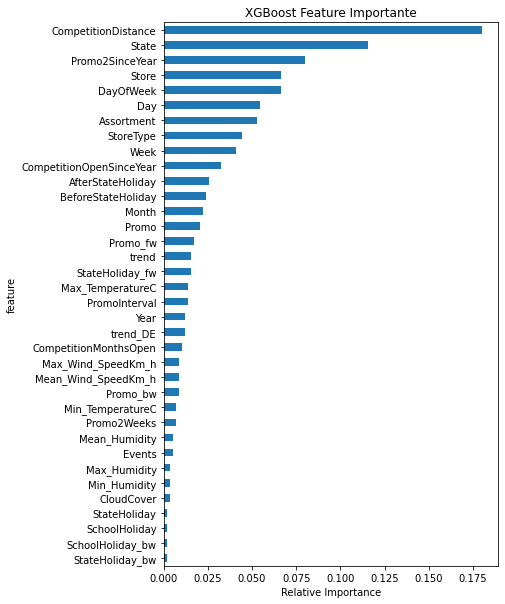

In [ ]:
importance = model_xg.get_fscore()
importante = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importante, columns=['feature', 'fscore'])
df['fscore'] = df['fscore']/df['fscore'].sum()

df.plot(kind = 'barh', x='feature', y='fscore', legend=False, figsize=(6,10))
plt.title('XGBoost Feature Importante')
plt.xlabel('Relative Importance')

In [ ]:
y_pred_train_log = model_xg.predict(xdata)
y_pred_val_log = model_xg.predict(xdata_val)
y_pred_test_log = model_xg.predict(xdata_test)

In [ ]:
y_pred_train = np.exp(y_pred_train_log*max_log_y)
y_pred_val = np.exp(y_pred_val_log*max_log_y)
y_pred_test = np.exp(y_pred_test_log*max_log_y)


In [ ]:
rmspe_train_log = rmspe(y_pred_train_log, y_train)
rmspe_val_log = rmspe(y_pred_val_log, y_valid)


In [ ]:
rmspe_train = rmspe(y_pred_train, y_train_orig)
rmspe_val = rmspe(y_pred_val, y_valid_orig)

In [ ]:
print(rmspe_train, rmspe_val)

0.33624730130357033 0.29856457098741135


In [ ]:
print(rmspe_train_log, rmspe_val_log)

0.04138541372778145 0.039077205277532445


In [ ]:
y_pred_val[1:5]

array([7009.492 , 6131.8066, 5921.641 , 6393.583 ], dtype=float32)

In [ ]:
y_valid_orig[1:5]

Date
2015-07-31    10460
2015-07-31     5085
2015-07-31     8663
2015-07-31     8363
Name: Sales, dtype: int64

In [ ]:
y_pred_test

array([ 5913.1475,  6176.2524,  6666.025 , ...,  4969.3887, 11547.521 ,
        5867.8423], dtype=float32)

In [ ]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submission_MLP_video_arbol.csv', index=False)

# LightGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
X_train.shape, X_valid.shape

((844329, 38), (9, 38))

In [ ]:
min_child_samples=5 #5
n_estimators=4000 #4000
learning_rate=0.05 #0.05
model_LGBM = LGBMRegressor(min_child_samples=min_child_samples, n_estimators=n_estimators, learning_rate=learning_rate )

In [ ]:
cat_vars

['Store',
 'Day',
 'DayOfWeek',
 'Month',
 'State',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'Events',
 'StateHoliday',
 'Assortment',
 'PromoInterval',
 'Year',
 'CompetitionMonthsOpen',
 'StoreType',
 'Week',
 'Promo2Weeks',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_fw',
 'StateHoliday_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

In [ ]:
fit_params={"early_stopping_rounds":100, #100
            "eval_metric" : 'l2', 
            "eval_set" : [(X_valid, y_valid)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature':  'auto'
           }

In [ ]:
model_LGBM.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.000484339	valid's l2: 0.000484339
[200]	valid's l2: 0.00029341	valid's l2: 0.00029341
[300]	valid's l2: 0.000217589	valid's l2: 0.000217589
[400]	valid's l2: 0.000187271	valid's l2: 0.000187271
[500]	valid's l2: 0.000143644	valid's l2: 0.000143644
[600]	valid's l2: 0.000134007	valid's l2: 0.000134007
[700]	valid's l2: 0.000121592	valid's l2: 0.000121592
[800]	valid's l2: 0.000110953	valid's l2: 0.000110953
[900]	valid's l2: 0.000101463	valid's l2: 0.000101463
[1000]	valid's l2: 9.48043e-05	valid's l2: 9.48043e-05
[1100]	valid's l2: 8.5862e-05	valid's l2: 8.5862e-05
[1200]	valid's l2: 7.9751e-05	valid's l2: 7.9751e-05
[1300]	valid's l2: 7.70951e-05	valid's l2: 7.70951e-05
[1400]	valid's l2: 6.9683e-05	valid's l2: 6.9683e-05
[1500]	valid's l2: 7.03386e-05	valid's l2: 7.03386e-05
Early stopping, best iteration is:
[1409]	valid's l2: 6.91858e-05	valid's l2: 6.91858e-05


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=4000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [ ]:
model_LGBM.score(X_valid, y_valid)

0.8998216132220473

In [ ]:
y_pred_train_log = model_LGBM.predict(X_train)
y_pred_val_log = model_LGBM.predict(X_valid)
y_pred_test_log = model_LGBM.predict(X_test)

In [ ]:
y_pred_train = np.exp(y_pred_train_log*max_log_y)
y_pred_val = np.exp(y_pred_val_log*max_log_y)
y_pred_test = np.exp(y_pred_test_log*max_log_y)


In [ ]:
rmspe_train_log = rmspe(y_pred_train_log, y_train)
rmspe_val_log = rmspe(y_pred_val_log, y_valid)


In [ ]:
rmspe_train = rmspe(y_pred_train, y_train_orig)
rmspe_val = rmspe(y_pred_val, y_valid_orig)

In [ ]:
print(rmspe_train, rmspe_val)

0.1526127823922954 0.08628992539966568


In [ ]:
print(rmspe_train_log, rmspe_val_log)

0.014228995414058246 0.009692888585364864


In [ ]:
y_pred_val[1:5]

array([10031.68313029,  5346.4009109 ,  8812.52600171,  9460.15518427])

In [ ]:
y_valid_orig[1:5]

Date
2015-07-31    10460
2015-07-31     5085
2015-07-31     8663
2015-07-31     8363
Name: Sales, dtype: int64

In [ ]:
y_pred_test

array([ 6273.23529535,  6455.57113474,  6697.14088615, ...,
        5514.06651029, 25445.37989332,  6620.10346525])

In [ ]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submission_MLP_video_arbolLGBM.csv', index=False)